# Batch Normalization
Ici nous explorerons le concept de batch normalization proposé par [3].  Puisque le code vous est fourni au complet, vous n'avez qu'une question à réponse à la fin de ce fichier.

[3] Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.

In [16]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from ift725.classifiers.fc_net import *
from ift725.data_utils import get_CIFAR10_data
from ift725.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from ift725.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print ('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


## Batch normalization: propagation avant
Dans le fichier `ift725/layers.py`, la fonction `forward_batch_normalization` effectue un propagation avant avec batchnorm.  Assurez-vous de bien comprendre le code. Le code que voici permet d'en tester la validité.

In [3]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print ('Before batch normalization:')
print ('  means: ', a.mean(axis=0))
print ('  stds: ', a.std(axis=0))

# Means should be close to zero and stds close to one
print ('After batch normalization (gamma=1, beta=0)')
a_norm, _ = forward_batch_normalization(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print ('  mean: ', a_norm.mean(axis=0))
print ('  std: ', a_norm.std(axis=0))

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = forward_batch_normalization(a, gamma, beta, {'mode': 'train'})
print ('After batch normalization (nontrivial gamma, beta)')
print ('  means: ', a_norm.mean(axis=0))
print ('  stds: ', a_norm.std(axis=0))

Before batch normalization:
  means:  [ 43.81082318 -14.21123429  -1.19984385]
  stds:  [31.6903091  30.49281267 29.2445104 ]
After batch normalization (gamma=1, beta=0)
  mean:  [ 1.81243909e-16 -2.48412402e-17 -3.05311332e-17]
  std:  [1.         0.99999999 0.99999999]
After batch normalization (nontrivial gamma, beta)
  means:  [11. 12. 13.]
  stds:  [1.         1.99999999 2.99999998]


In [5]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in range(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  forward_batch_normalization(a, gamma, beta, bn_param)
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = forward_batch_normalization(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

After batch normalization (test-time):
  means:  [0.13426432 0.04593478 0.03648662]
  stds:  [1.03107554 0.88677929 1.04074987]


## Batch Normalization: rétro-propagation
la rétro-propagation de batch norm est dans la fonction `backward_batch_normalization`.  Ici aussi, assurez-vous de bien comprendre le code.  La cellule suivante effectue une vérification dilligente du gradient.

In [6]:
# Gradient check batchnorm backward pass

N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: forward_batch_normalization(x, gamma, beta, bn_param)[0]
fg = lambda a: forward_batch_normalization(x, gamma, beta, bn_param)[0]
fb = lambda b: forward_batch_normalization(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = forward_batch_normalization(x, gamma, beta, bn_param)
dx, dgamma, dbeta = backward_batch_normalization(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.1063290866624405e-09
dgamma error:  8.799133453554378e-12
dbeta error:  1.2616030246105504e-11


## Batch Normalization: alternative backward
Voici une version alternative de la batch norm.

In [7]:
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = forward_batch_normalization(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = backward_batch_normalization(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = backward_batch_normalization_alternative(dout, cache)
t3 = time.time()

print('dx difference: ', rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ', rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

dx difference:  1.6770176053936761e-12
dgamma difference:  0.0
dbeta difference:  0.0
speedup: 0.84x


# Question 1

Suivant le code de la fonction `forward_batch_normalization` expliquez mathématiquement l'opération effectuée en mode `train` et en mode `test`

## Votre réponse ...

# Question 2

Suivant le code de la fonction `backward_batch_normalization` expliquez mathématiquement l'opération effectuée.

## Votre réponse ...

## Réseaux pleinement connectés et Batch Normalization
Maintenant que vous comprenez en quoi consiste la *batch normalization*, allez dans votre classe `FullyConnectedNeuralNet` du fichier `ift725/classifiers/fc_net.py` et modifiez le code afin d'include la batch normalization à vos réseaux de neurones.

Plus spécifiquement, lorsque la variable `use_batchnorm` est à `True` dans le constructeur, vous devriez ajouter une couche *batch norma*  **avant** chaque couche ReLU. De plus, la sortie de la dernière couche **ne doit pas** être normalisée. Une fois fait, vérifiez votre implantation avec le code que voici.


In [11]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print ('Running check with reg = ', reg)
  model = FullyConnectedNeuralNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            use_batchnorm=True)

  loss, grads = model.loss(X, y)
  print ('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  if reg == 0: print

Running check with reg =  0
Initial loss:  2.3741488023367205
W1 relative error: 7.16e-05
W2 relative error: 8.91e-06
W3 relative error: 4.53e-10
b1 relative error: 1.60e-06
b2 relative error: 4.11e-07
b3 relative error: 1.44e-10
beta1 relative error: 3.84e-08
beta2 relative error: 6.20e-09
gamma1 relative error: 3.44e-08
gamma2 relative error: 5.24e-09
Running check with reg =  3.14
Initial loss:  11.877419485682841
W1 relative error: 9.16e-08
W2 relative error: 2.19e-05
W3 relative error: 7.67e-09
b1 relative error: 2.02e-08
b2 relative error: 1.92e-07
b3 relative error: 3.63e-10
beta1 relative error: 3.39e-08
beta2 relative error: 2.15e-07
gamma1 relative error: 2.41e-07
gamma2 relative error: 5.61e-08


Exécutez ce code pour entraîner un réseau de neurones à 6 couches sur 1000 images de CIFAR10 avec et sans batch normalization.

In [12]:
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNeuralNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
model = FullyConnectedNeuralNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
bn_solver.train()

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
solver.train()

(Iteration 1 / 200) loss: 2.252665
(Epoch 0 / 10) train acc: 0.168000; val_acc: 0.132000
(Epoch 1 / 10) train acc: 0.360000; val_acc: 0.286000
(Epoch 2 / 10) train acc: 0.463000; val_acc: 0.317000
(Epoch 3 / 10) train acc: 0.519000; val_acc: 0.321000
(Epoch 4 / 10) train acc: 0.581000; val_acc: 0.309000
(Epoch 5 / 10) train acc: 0.612000; val_acc: 0.299000
(Epoch 6 / 10) train acc: 0.647000; val_acc: 0.300000
(Epoch 7 / 10) train acc: 0.699000; val_acc: 0.318000
(Epoch 8 / 10) train acc: 0.732000; val_acc: 0.302000
(Epoch 9 / 10) train acc: 0.768000; val_acc: 0.324000
(Epoch 10 / 10) train acc: 0.795000; val_acc: 0.322000
(Iteration 1 / 200) loss: 2.303273
(Epoch 0 / 10) train acc: 0.159000; val_acc: 0.128000
(Epoch 1 / 10) train acc: 0.235000; val_acc: 0.210000
(Epoch 2 / 10) train acc: 0.306000; val_acc: 0.274000
(Epoch 3 / 10) train acc: 0.353000; val_acc: 0.280000
(Epoch 4 / 10) train acc: 0.368000; val_acc: 0.285000
(Epoch 5 / 10) train acc: 0.449000; val_acc: 0.326000
(Epoch 6 / 

## Visualisation

/home/aurios/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/home/aurios/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/aurios/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuse

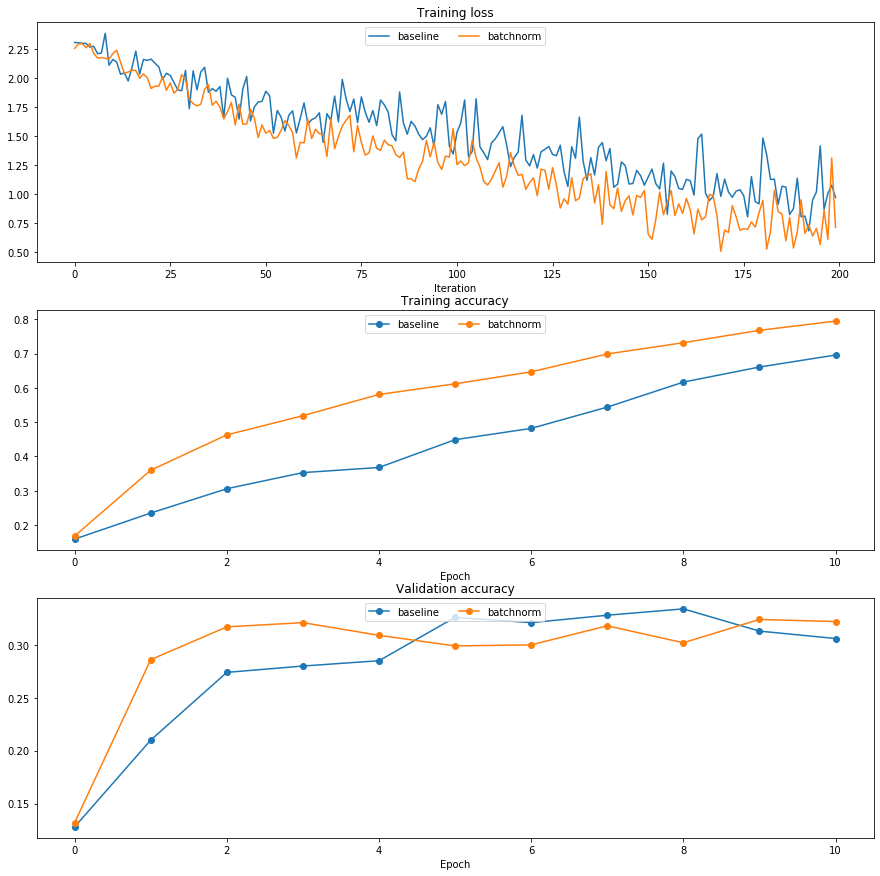

In [13]:
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, '-', label='baseline')
plt.plot(bn_solver.loss_history, '-', label='batchnorm')

plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, '-o', label='baseline')
plt.plot(bn_solver.train_acc_history, '-o', label='batchnorm')

plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, '-o', label='baseline')
plt.plot(bn_solver.val_acc_history, '-o', label='batchnorm')
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Batch normalization et initialisation
Les dernières cellules de ce notebook a pour objectif d'illustrer l'intéraction qu'il y a entre *batch norm* et l'initialisation d'un réseau de neurones.

Dans la première cellule nous entraînerons un réseau à 8 couches avec et sans *batch normalization* avec différentes échelles (*scales*) d'initialisation des poids. Ensuite nous afficherons la justesse en entrainement, en validation ainsi que la perte obtenues pour différents échelles d'initialisation.

In [14]:
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers = {}
solvers = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
  print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
  bn_model = FullyConnectedNeuralNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
  model = FullyConnectedNeuralNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

  bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  bn_solver.train()
  bn_solvers[weight_scale] = bn_solver

  solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  solver.train()
  solvers[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


/mnt/d/Users/drake/OneDrive/Documents/School/5ASherbrooke/IFT725-NeuronalNetworks/TPs/TP2/ift725/layers.py:670: RuntimeWarning: divide by zero encountered in log
  loss = np.sum( - np.log(softmax[range(N), y]) )


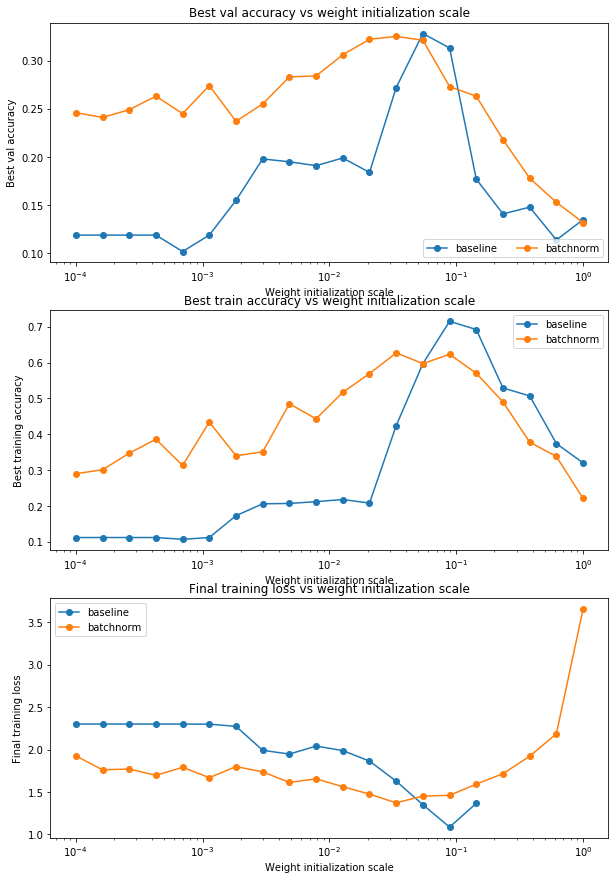

In [15]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
  best_train_accs.append(max(solvers[ws].train_acc_history))
  bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))
  
  best_val_accs.append(max(solvers[ws].val_acc_history))
  bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))
  
  final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
  bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history[-100:]))
  
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()

plt.gcf().set_size_inches(10, 15)
plt.show()

# Question 3:
Quelle(s) conclusion(s) tirez-vous de ces courbes?

## Votre réponse:...
